# Example Notebook


### Contents:  
* Load superstore data and aggregate by category unit sales, daily demand.
* Transform DataFrame to wide data format to support covariates
* Visualize with lineplots
* Forecast sales unit volume for each category - furniture, office supplies, technology. 
* Illustrate the use of sforecast with three examples
  * univariate forecasting of unit sales volume for office supplies
  * univariate forecasting with the presense of covariates
  * multivariate forecasting including furniture, office supplies, and technology

In [1]:
import sforecast as sf
print(f'sforecast version = {sf.__version__}')
import pandas as pd
import beautifulplots as bp
from datetime import datetime
from xgboost import XGBRegressor

sforecast version = 0.1.0


## Load Data

The data for these examples is derived from the Superstore dataset avaliable [here](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls). For this exercise, prior to loadingl, the data is pre-processed including the following
* contiguous dates - ensure that there are no missing dates
* aggregate to category - the original dateset containes categories, sub-categories, and product ids. 
* the EDA data processing notebook is found at the following link - [Superstore EDA](https://github.com/Aljgutier/sforecast/blob/main/docs/forecast_EDA_Superstore.ipynb)

In [2]:
df_sales = pd.read_csv("../data/Superstore_subcatsales_2017_cdp.csv", parse_dates = ["Order Date"])
display(df_sales.head(10))

,Order Date,Category,Sub-Category,Sales,Quantity
0,2014-01-03,Office Supplies,Paper,16.448,2.0
1,2014-01-04,Office Supplies,Labels,11.784,3.0
2,2014-01-04,Office Supplies,Binders,3.540,2.0
3,2014-01-04,Office Supplies,Paper,0.000,0.0
4,2014-01-04,Office Supplies,Storage,272.736,3.0
5,2014-01-05,Office Supplies,Labels,0.000,0.0
6,2014-01-05,Office Supplies,Binders,0.000,0.0
7,2014-01-05,Office Supplies,Paper,0.000,0.0
8,2014-01-05,Office Supplies,Art,19.536,3.0
9,2014-01-05,Office Supplies,Storage,0.000,0.0


Basic Stats

In [3]:
print(f'date min = {df_sales["Order Date"].min()}')
print(f'date max = {df_sales["Order Date"].max()}')
print(f'N rows (sales) = {df_sales.shape[0]}')
print( f'N Sub-Catetories = {df_sales.groupby("Sub-Category")["Sales"].count().count()} ')

date min = 2014-01-03 00:00:00
date max = 2017-12-30 00:00:00
N rows (sales) = 24431
N Sub-Catetories = 17 


## Sales by Category Time-Series

* aggregate category sales by date
* three categories - office supplies, furniture, technology
* lineplots to observe the timeseries

In [4]:
aggs = {
    "Sales":"sum",
    "Quantity":"sum"  
}

df_catsales = df_sales.groupby(["Order Date" , "Category"]).agg(aggs).reset_index()
df_catsales.head(10)

,Order Date,Category,Sales,Quantity
0,2014-01-03,Office Supplies,16.448,2.0
1,2014-01-04,Office Supplies,288.060,8.0
2,2014-01-05,Office Supplies,19.536,3.0
3,2014-01-06,Furniture,2573.820,9.0
4,2014-01-06,Office Supplies,685.340,15.0
5,2014-01-06,Technology,1147.940,6.0
6,2014-01-07,Furniture,76.728,3.0
7,2014-01-07,Office Supplies,10.430,7.0
8,2014-01-07,Technology,0.000,0.0
9,2014-01-08,Furniture,0.000,0.0


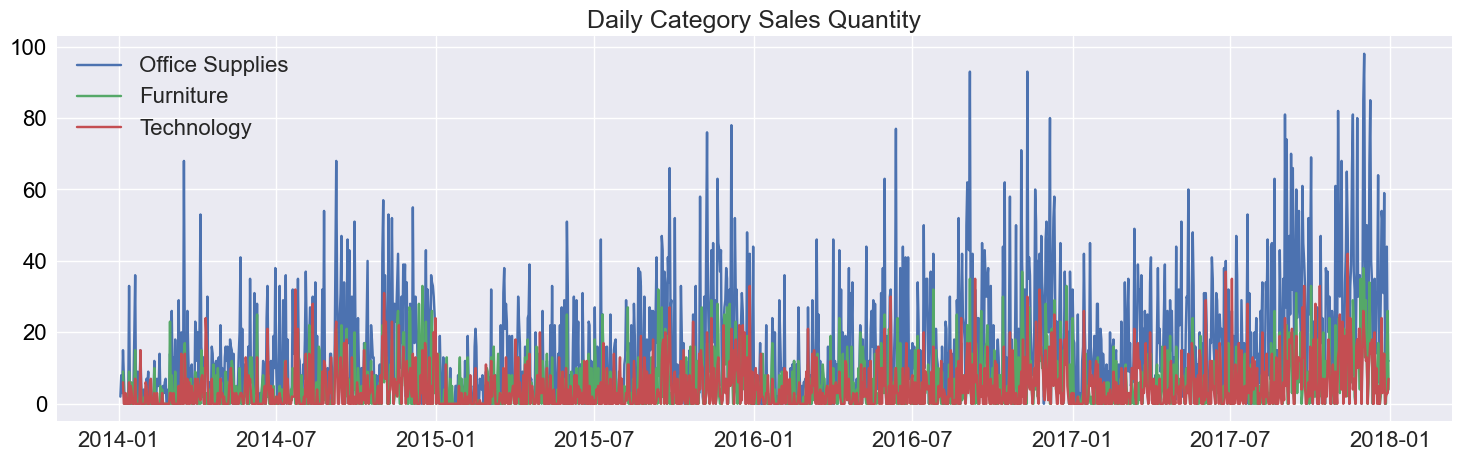

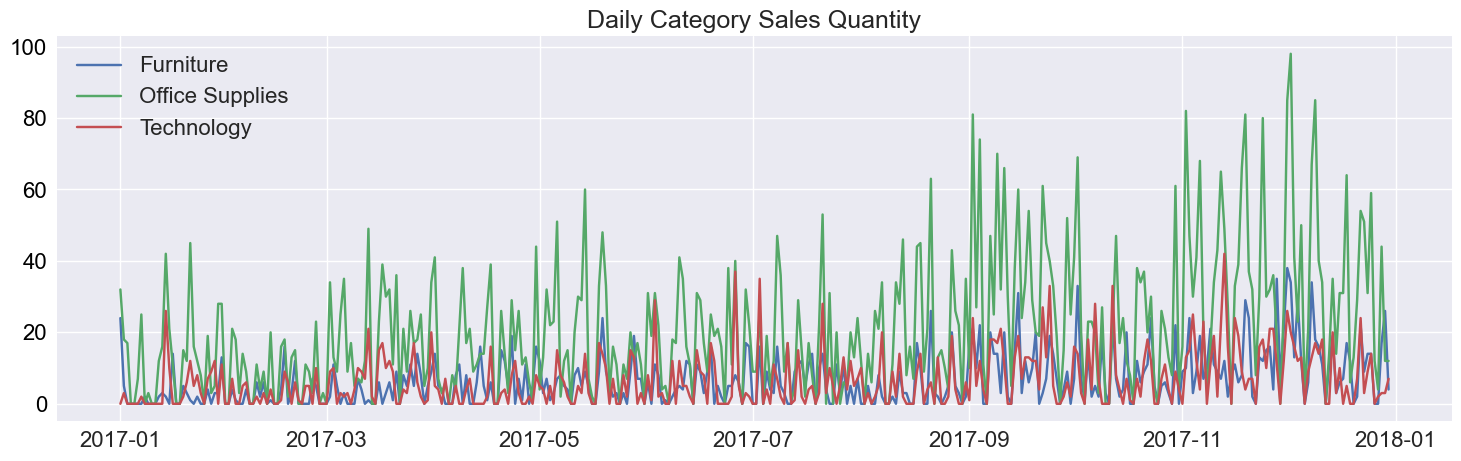

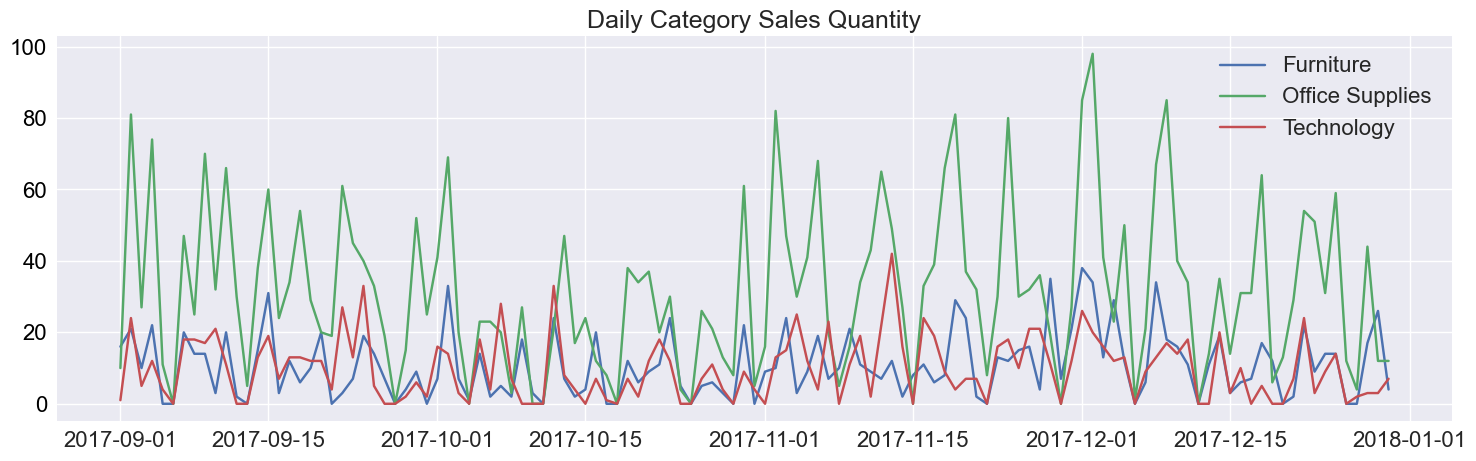

In [5]:

bp.lineplot(df_catsales,"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,1,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,9,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" ,
            title = "Daily Category Sales Quantity", figsize=(18,5))

## Wide (Multivariate) Format

* Pivot to wide format
* We are interested in forecasting unit sales volume. For these examples, we do not need the sales revenue columns

In [5]:
dfXYw = df_catsales.copy()

def to_flat_columns(hier_cols):
    flat_cols=[]
    for clist in hier_cols:
        for n,ci in enumerate(clist):
            c = ci if n == 0 else c+"_"+ci 
        flat_cols.append(c)
    return flat_cols

dp = "Order Date" # demand period

# note that the demand period (dp) = "Order Date" becomes the index
dfXYw = dfXYw.pivot(index=dp, columns = "Category" , values = ["Quantity" , "Sales"] )
flat_cols = to_flat_columns(dfXYw.columns)
dfXYw.columns = flat_cols 
dfXYw = dfXYw.fillna(0)

dfXYw.head()

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Sales_Furniture,Sales_Office Supplies,Sales_Technology
Order Date,,,,,,
2014-01-03,0.0,2.0,0.0,0.000,16.448,0.00
2014-01-04,0.0,8.0,0.0,0.000,288.060,0.00
2014-01-05,0.0,3.0,0.0,0.000,19.536,0.00
2014-01-06,9.0,15.0,6.0,2573.820,685.340,1147.94
2014-01-07,3.0,7.0,0.0,76.728,10.430,0.00


## Univariate Forecast

* Univariate forecast considers only one variable
  * Quantity_Furniture
* It requires 3 inputs to initialize sforecast
    * ML Model
    * forecast variable, y = "Quantity_furniture"
    * ts_parameters for defining the timeseries sliding window forecast
        * Below, the sliding model is set to forecast Npred = 30 periods (days)
        * Nhorizon = 1 , each forecast will be over 1 period (single-step forecast)
        * The univariate (y) will be lagged over 40 days. Each row will contain lags from 1 to 40 for each covariate (in this case y = "Quantity_Furniture"). The next two examples will also include covariates.
        * see sforecast [sforecast](https://sforecast.readthedocs.io/en/latest/) documentaton 
* By default the sliding model will scale the input variables with the SKlearn minmax scaler. However, there is an option to scale with the StandardScaler. See the [sforecast](https://sforecast.readthedocs.io/en/latest/) documentaton for more information.
* forecast with sf.forecast
* join the forecast result, df_pred_uv, with the input DataFrame dfXY
* Retrieve the forecast metrics from sforecast.metrics
  * we get an RMSE of 10.94 and MAE of 8.82
* plot the forecast observations and predictions with a lineplot

In [6]:

dfXY = dfXYw[["Quantity_Furniture"]]


print('dfXY',end="")
display(dfXY.head())

ts_params = {
    "Npred":30,
    "Nhorizon":1,
    "Nlag":40,
    "minmax" :(0,None)}  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfuv = sf.sforecast(y = y, ts_parameters=ts_params,model=xgb_model)

df_pred_uv = sfuv.forecast(dfXY)


print(f'\nmetrics = {sfuv.metrics}')
dfXY_pred_uv = dfXY.join(df_pred_uv)
display(dfXY_pred_uv)


dfXY

,Quantity_Furniture
Order Date,
2014-01-03,0.0
2014-01-04,0.0
2014-01-05,0.0
2014-01-06,9.0
2014-01-07,3.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 10.93991802246071, 'MAE': 8.818413734436035}}


,Quantity_Furniture,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,
2014-01-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-26,0.0,NaN,0.0,8.522676,-8.522676,0.000000,26.245546
2017-12-27,0.0,NaN,0.0,5.819362,-5.819362,0.000000,23.542233
2017-12-28,17.0,NaN,17.0,10.800791,6.199209,0.698584,28.523662


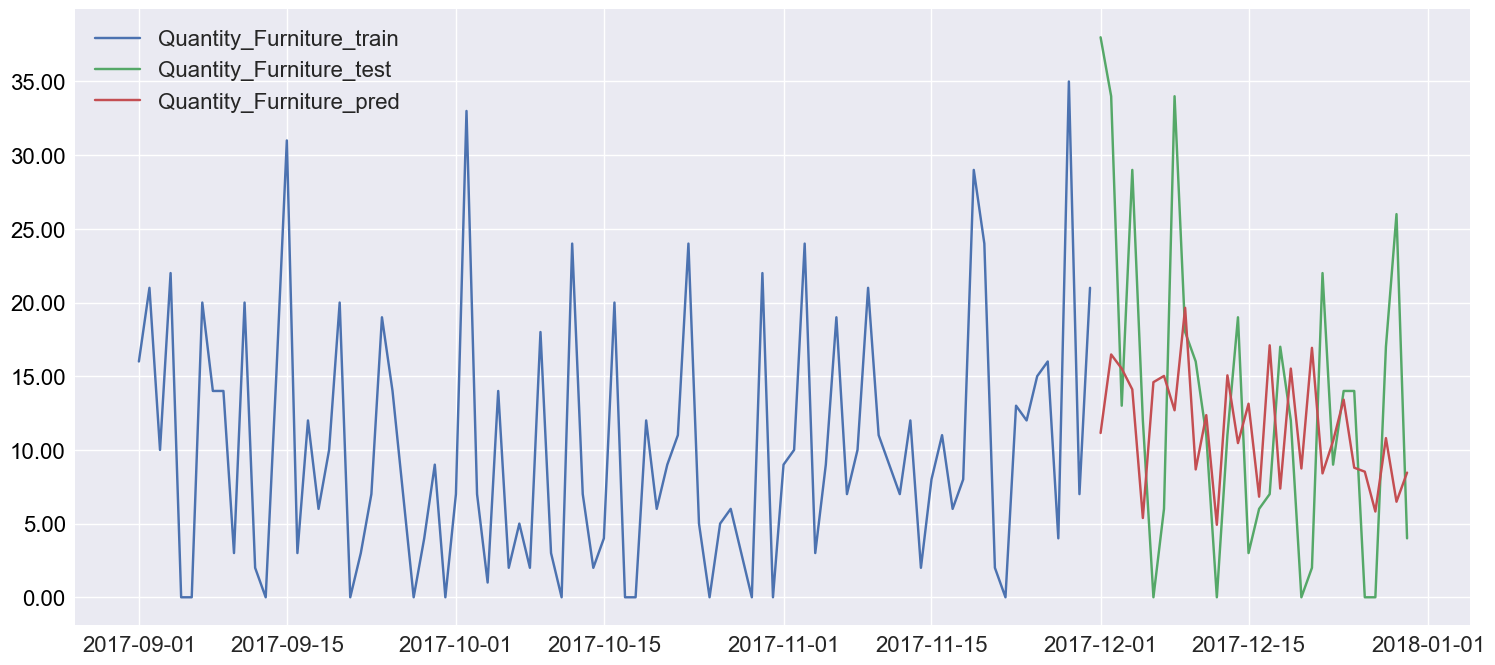

In [7]:

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfuv = dfXY_pred_uv.reset_index().copy()
yfillbetween = (y+"_pred_lower",y+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfuv[dfuv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8) , legend=True)

## Univariate Forecast with Covariates

* this case is similar to the previous one, but also includes the covariates in the dfXY dataset
* initialize the sliding window model as before
* we must declare the covariates so that they are accounted for properly - unlagged covariates are not included in the training set
* we have a improved forecast accuracy for y = Quantity_Furniture: RMSE': 9.83, 'MAE': 7.36
* when comparing the previous example's lineplot we notice improved accuracy. In this example the predicted line follows the actual ("test") line a little more closely. 

In [3]:

print('dfXY',end="")
display(dfXY.head())


dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]]
y = ["Quantity_Furniture"]
Npred = 30

ts_params = {
    "Npred":Npred,
    "Nhorizon":1,
    "Nlag":40,
    "minmax" :(0,None),
    "co_vars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 
sfuvc = sf.sforecast(y = y, ts_parameters=ts_params,model=xgb_model)
df_pred_uvc = sfuvc.forecast(dfXY)

print(f'\nmetrics = {sfuvc.metrics}')
dfXY_pred_uvc = dfXY.join(df_pred_uvc)
display(dfXY_pred_uvc)

dfXY

NameError: name 'dfXY' is not defined

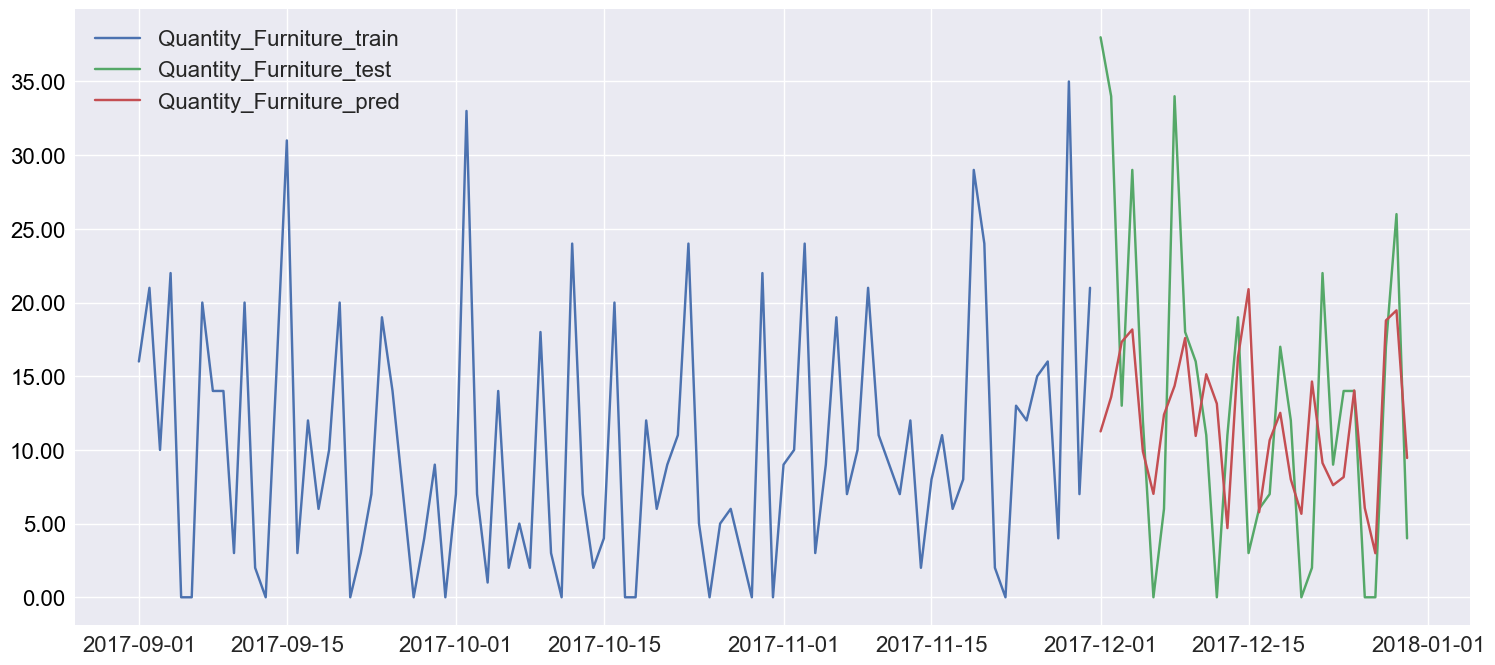

In [9]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfuvc = dfXY_pred_uvc.reset_index().copy()

d=datetime(2017,9,1)
bp.lineplot(dfuvc[dfuvc["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8))

## Multivariate Forecast
* This case is again very similar to the previous examples
* Again we inclue the co-variate variables but now we also forecast the co-variates
* In this case, sforecast loops through these variables and creates the forecasts
* Note that for more advanced types of models, such as deep-learning models the multivarites forecasts can be generated simultaneously
* We display the upper and lower prediction bounds, included with the prediction output.

In [11]:
dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]]


print('dfXY',end="")
display(dfXY.head())

y = [ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]
Npred = 30


# sliding forecast inputs
ts_params = {
    "Npred":Npred,
    "Nhorizon":1,
    "Nlag":40,
    "minmax" :(0,None),
    "co_vars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 


xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

# sliding forecast model and forecast
sfmv = sf.sforecast(y = y, ts_parameters=ts_params,model=xgb_model)
df_pred_mv = sfmv.forecast(dfXY)


print(f'\nmetrics = {sfmv.metrics}')
dfXY_pred_mv = dfXY.join(df_pred_mv)
display(dfXY_pred_mv)

dfXY

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology
Order Date,,,
2014-01-03,0.0,2.0,0.0
2014-01-04,0.0,8.0,0.0
2014-01-05,0.0,3.0,0.0
2014-01-06,9.0,15.0,6.0
2014-01-07,3.0,7.0,0.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 9.826672736184616, 'MAE': 7.359953657786051}, 'Quantity_Office Supplies_pred': {'RMSE': 24.741110974219684, 'MAE': 17.99593949317932}, 'Quantity_Technology_pred': {'RMSE': 7.7072110450166145, 'MAE': 6.491455149650574}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper,Quantity_Office Supplies_train,...,Quantity_Office Supplies_pred,Quantity_Office Supplies_pred_error,Quantity_Office Supplies_pred_lower,Quantity_Office Supplies_pred_upper,Quantity_Technology_train,Quantity_Technology_test,Quantity_Technology_pred,Quantity_Technology_pred_error,Quantity_Technology_pred_lower,Quantity_Technology_pred_upper
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,NaN,0.0,6.055835,-6.055835,0.000000,19.622014,NaN,...,30.671810,-18.671810,11.409154,65.602387,NaN,0.0,12.978919,-12.978919,1.492448,21.535302
2017-12-27,0.0,4.0,2.0,NaN,0.0,2.989914,-2.989914,0.000000,16.556093,NaN,...,4.507528,-0.507528,0.000000,39.438105,NaN,2.0,4.494198,-2.494198,0.000000,13.050582
2017-12-28,17.0,44.0,3.0,NaN,17.0,18.785179,-1.785179,11.204631,32.351358,NaN,...,30.113577,13.886423,10.850921,65.044154,NaN,3.0,12.835868,-9.835868,1.349397,21.392251


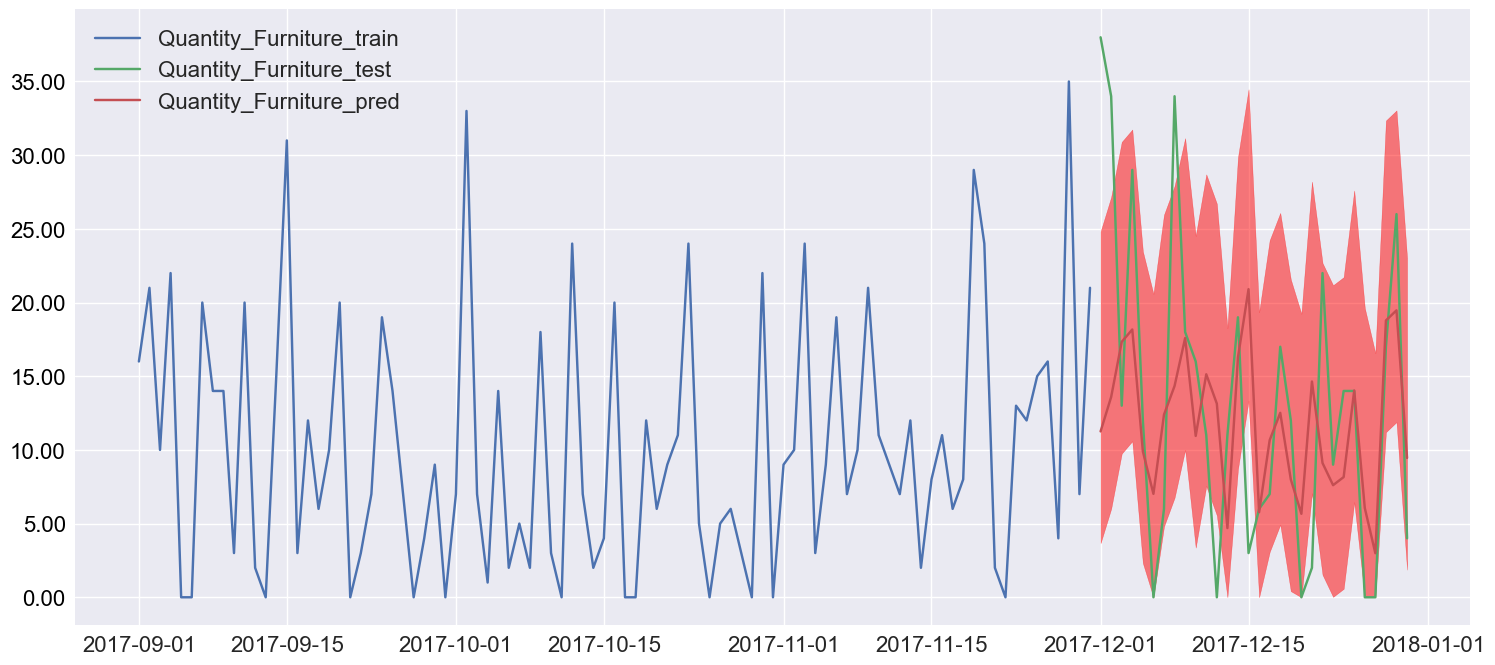

In [12]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfmv = dfXY_pred_mv.reset_index().copy()

yfillbetween = (y+"_pred_lower",y+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfmv[dfmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , yfb=yfillbetween, figsize=(18,8) , legend=True)

## Conclusions, Summary, and Next Steps
* We demonstrated typical data loading and pre-processing steps.
* Further documentation of [sforecast](https://sforecast.readthedocs.io/en/latest/) are available in read the docs.
* Several forecast examples were demonstrated: univarate, univariate with covariates, and multivariate
* Though not demonstrated here, the addition of exogenous variables is straightfoward. Input columns that are not designated as covariates are treated as co-variates. Sforecast does not apply lags to exogenous variables. 
* Future sforecast features (under development) will include DL LSTM forecast model, which is expected to offer improved performance.

## Help and Readthedocs

### https://sforecast.readthedocs.io/en/latest/

In [73]:
help(sf.sforecast)

Help on class sforecast in module sforecast.sforecast:

class sforecast(builtins.object)
 |  sforecast(y='y', model=None, ts_parameters=None)
 |  
 |  Siding/expanding window forecast model.
 |  
 |  **__init__(self,  y="y", model=None, ts_parameters=None)**
 |   Recieves inputs defining the sliding forecast model including ML model, and time-series sliding/expanding window hyper-parameters.
 |      
 |      Args:
 |          y (str or list): Forecast (dependent) variable(s). Defaults to "y".
 |          model (ML model): SKLearn model. Defaults to None.
 |          ts_parameters (dictionary): Dictionary of sliding/expanding window forecast model hyperparameters. Defaults to "None".
 |          
 |              Nobserve (int): number of observations to include in the training data (counting back from the first prediction).
 |          
 |              Nlag (int): Add a lagged variable to the training from 1 to Nlag for each of the covariates. Lagged variables enable accounting for the 